In [1]:
# TensorFlow and tf.keras
import tensorflow as tf

# Helper libraries
import numpy as np
import json
import bz2
import pandas as pd
import matplotlib.pyplot as plt

print(tf.__version__)

2.3.0


In [2]:
from PIL import PngImagePlugin  
LARGE_ENOUGH_NUMBER = 100
PngImagePlugin.MAX_TEXT_CHUNK = LARGE_ENOUGH_NUMBER * (1024**2) # to avoid corrupted .png images

In [3]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  2


In [4]:
topics = [
  'Culture.Biography.Biography*',
 'Culture.Food and drink',
 'Culture.Internet culture',
 'Culture.Linguistics',
 'Culture.Literature',
 'Culture.Media.Books',
 'Culture.Media.Entertainment',
 'Culture.Media.Films',
 'Culture.Media.Media*',
 'Culture.Media.Music',
 'Culture.Media.Radio',
 'Culture.Media.Software',
 'Culture.Media.Television',
 'Culture.Media.Video games',
 'Culture.Performing arts',
 'Culture.Philosophy and religion',
 'Culture.Sports',
 'Culture.Visual arts.Architecture',
 'Culture.Visual arts.Comics and Anime',
 'Culture.Visual arts.Fashion',
 'Culture.Visual arts.Visual arts*',
 'Geography.Geographical',
 'History and Society.Business and economics',
 'History and Society.Education',
 'History and Society.History',
 'History and Society.Military and warfare',
 'History and Society.Politics and government',
 'History and Society.Society',
 'History and Society.Transportation',
 'STEM.Biology',
 'STEM.Chemistry',
 'STEM.Computing',
 'STEM.Earth and environment',
 'STEM.Engineering',
 'STEM.Libraries & Information',
 'STEM.Mathematics',
 'STEM.Medicine & Health',
 'STEM.Physics',
 'STEM.STEM*',
 'STEM.Space',
 'STEM.Technology']

In [5]:
training_set = pd.read_pickle("/dlabdata1/piccardi/WikipediaImageClassification/training_set.pkl")\
            .sample(750000, random_state=0)
training_set['full_path'] = training_set.image_path.apply(lambda r: '/scratch/WIT_Dataset/images'+r)
training_set[['full_path', 'labels']]

,full_path,labels
736437,/scratch/WIT_Dataset/images/5/54/The_Return_of...,"[Geography.Regions.Europe.Europe*, Geography.R..."
20148,/scratch/WIT_Dataset/images/a/a2/PIA20862-Cere...,"[STEM.Space, STEM.STEM*]"
2770647,/scratch/WIT_Dataset/images/f/fa/Grimsby_-_The...,"[Geography.Regions.Europe.Europe*, Geography.R..."
1930902,/scratch/WIT_Dataset/images/9/93/Gisborne_nz_2...,"[Geography.Regions.Oceania, Geography.Geograph..."
1373350,/scratch/WIT_Dataset/images/1/1d/Rear_Admiral_...,"[Geography.Regions.Europe.Europe*, History and..."
...,...,...
573330,/scratch/WIT_Dataset/images/c/c9/Michaela_Diet...,"[Culture.Media.Television, History and Society..."
1336166,/scratch/WIT_Dataset/images/3/35/HMS_Concorde_...,"[History and Society.Military and warfare, His..."
752022,/scratch/WIT_Dataset/images/2/2b/FrozenWaterFa...,"[Geography.Geographical, Geography.Regions.Asi..."
985499,/scratch/WIT_Dataset/images/e/ef/Borová_Lada_-...,"[Geography.Regions.Europe.Eastern Europe, Geog..."


In [6]:
weights = training_set[["labels", "page_title"]].explode("labels")\
        .groupby("labels").agg("count").reset_index()
total = weights.page_title.sum()
weights['proportion'] = weights.page_title.apply(lambda r: r/total)
weights['weight'] = weights.page_title.apply(lambda r: (1/r)*(total/41))
# weights['weight'] = weights.page_title.apply(lambda r: np.log((1/r)*(total/2)))

weights = weights[['labels', 'proportion', 'weight']]
weights

,labels,proportion,weight
0,Culture.Biography.Biography*,0.077474,0.314819
1,Culture.Biography.Women,0.011208,2.176237
2,Culture.Food and drink,0.005613,4.345038
3,Culture.Internet culture,0.000943,25.872341
4,Culture.Linguistics,0.001174,20.770328
...,...,...,...
59,STEM.Medicine & Health,0.003968,6.146468
60,STEM.Physics,0.000990,24.631233
61,STEM.STEM*,0.060826,0.400983
62,STEM.Space,0.003626,6.727200


In [7]:
from tensorflow import keras 
from tensorflow.keras.preprocessing.image import ImageDataGenerator

width, height = 64, 64
target_size = (height, width)
print('1')
datagen = ImageDataGenerator(#rescale=1./255, 
                             rotation_range=40, 
                             width_shift_range=0.2,
                             height_shift_range=0.2, 
#                              shear_range=0.2,
                             zoom_range=0.2,
                             horizontal_flip=True,
                             fill_mode='nearest',
                             validation_split=0.05, 
                             ) 
print('2')

train_generator = datagen.flow_from_dataframe(
        dataframe=training_set, 
#         directory='/scratch/WIT_Dataset/images/', 
        subset='training',
        classes=topics,
        color_mode='rgb',
        x_col='full_path', 
        y_col='labels', 
        class_mode='categorical', 
        batch_size=64,
#         validate_filenames=False, 
        target_size=target_size,
#         shuffle=False
        )
print('3')

validation_generator = datagen.flow_from_dataframe(
        dataframe=training_set, 
#         directory='/scratch/WIT_Dataset/images/', 
        subset='validation',
        classes=topics,
        color_mode='rgb',
        x_col='full_path', 
        y_col='labels', 
        class_mode='categorical', 
#         validate_filenames=False, 
        target_size=target_size,
#         shuffle=False
        )
print('4')


1
2


/home/matvieir/anaconda3/lib/python3.8/site-packages/keras_preprocessing/image/dataframe_iterator.py:279: UserWarning: Found 61995 invalid image filename(s) in x_col="full_path". These filename(s) will be ignored.
  warnings.warn(


Found 552062 validated image filenames belonging to 41 classes.
3


/home/matvieir/anaconda3/lib/python3.8/site-packages/keras_preprocessing/image/dataframe_iterator.py:279: UserWarning: Found 61995 invalid image filename(s) in x_col="full_path". These filename(s) will be ignored.
  warnings.warn(


Found 29055 validated image filenames belonging to 41 classes.
4


In [8]:
name_id_map = train_generator.class_indices
class_names = len(name_id_map)*[0]
for k in name_id_map.keys():
    class_names[name_id_map[k]] = k

In [9]:
CLASS_LABELS = list(name_id_map.keys())

In [10]:
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import optimizers
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

efficient_net = EfficientNetB0(include_top=False, weights='imagenet', classes=len(CLASS_LABELS),
                                       input_shape=(width, height, 3))
efficient_net.trainable = False

model = Sequential([
    efficient_net,
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(len(CLASS_LABELS), activation='sigmoid')
])

model.compile(optimizer=tf.keras.optimizers.Adam(),
              loss=tf.nn.sigmoid_cross_entropy_with_logits,
              metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
efficientnetb0 (Functional)  (None, 2, 2, 1280)        4049571   
_________________________________________________________________
flatten (Flatten)            (None, 5120)              0         
_________________________________________________________________
dense (Dense)                (None, 128)               655488    
_________________________________________________________________
dense_1 (Dense)              (None, 41)                5289      
Total params: 4,710,348
Trainable params: 660,777
Non-trainable params: 4,049,571
_________________________________________________________________


To test later: train also some layers of EfficientNet. https://www.tensorflow.org/tutorials/images/transfer_learning#un-freeze_the_top_layers_of_the_model

In [31]:

# Let's take a look to see how many layers are in the base model
# print("Number of layers in the base model: ", len(efficient_net.layers))

# # Let's take a look to see how many layers are in the base model
# print("Number of layers in the base model: ", len(efficient_net.layers))

# # Fine-tune from this layer onwards
# fine_tune_at = 100

# # Freeze all the layers before the `fine_tune_at` layer
# for layer in efficient_net.layers[:fine_tune_at]:
#     layer.trainable = False

Number of layers in the base model:  237


In [11]:
class_weight={}
for l in name_id_map.keys():
    w = weights[weights.labels==l].weight.iloc[0]
    class_weight[train_generator.class_indices[l]] = w
class_weight

{0: 0.31481881699487657,
 1: 4.345037607414316,
 2: 25.872341179807144,
 3: 20.770327574921023,
 4: 3.5779237651673,
 5: 18.516127668211496,
 6: 7.883157985698546,
 7: 7.771869043097357,
 8: 1.2119402704171836,
 9: 2.788101717491878,
 10: 40.639659204811224,
 11: 60.407819225251075,
 12: 7.674692755838164,
 13: 39.70298304470033,
 14: 8.50462051204363,
 15: 1.3680512423815634,
 16: 0.9222249273819071,
 17: 0.6538731473174554,
 18: 38.225133997939835,
 19: 16.466392906297237,
 20: 0.5004311931994672,
 21: 0.7251267899884843,
 22: 2.0706701382419617,
 23: 3.284164341643416,
 24: 1.1489416970420834,
 25: 0.8782690075182058,
 26: 0.8955760342650467,
 27: 1.901524487950787,
 28: 0.7999357689963741,
 29: 0.855448420401159,
 30: 26.580643203146813,
 31: 19.560627177700347,
 32: 3.8987013357028513,
 33: 1.7957599016417913,
 34: 25.985650703222362,
 35: 172.81719156997394,
 36: 6.1464677940978305,
 37: 24.63123256232562,
 38: 0.4009830161677351,
 39: 6.727199823018639,
 40: 3.5395050172414626}

In [12]:
epochs=15

history = model.fit(
  train_generator,
  verbose=1,
  validation_data=validation_generator,
  epochs=epochs,
  class_weight=class_weight
)

Epoch 1/15
8626/8626 [==============================] - 4680s 543ms/step - loss: 0.9752 - accuracy: 0.0208 - val_loss: 0.6930 - val_accuracy: 0.0236
Epoch 2/15
8626/8626 [==============================] - 1542s 179ms/step - loss: 0.9749 - accuracy: 0.0272 - val_loss: 0.6930 - val_accuracy: 0.0272
Epoch 3/15
8626/8626 [==============================] - 1554s 180ms/step - loss: 0.9748 - accuracy: 0.0325 - val_loss: 0.6929 - val_accuracy: 0.0446
Epoch 4/15
8626/8626 [==============================] - 1652s 192ms/step - loss: 0.9748 - accuracy: 0.0450 - val_loss: 0.6929 - val_accuracy: 0.0612
Epoch 5/15
8626/8626 [==============================] - 3056s 354ms/step - loss: 0.9748 - accuracy: 0.0748 - val_loss: 0.6930 - val_accuracy: 0.1080
Epoch 6/15
8626/8626 [==============================] - 3658s 424ms/step - loss: 0.9749 - accuracy: 0.1103 - val_loss: 0.6929 - val_accuracy: 0.1385
Epoch 7/15
8626/8626 [==============================] - 1542s 179ms/step - loss: 0.9749 - accuracy: 0.1208

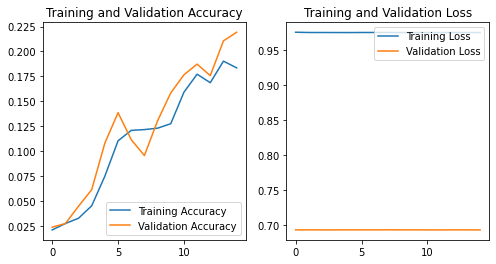

In [13]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [14]:
model.save('saved_model_imagenet')

In [15]:
vg = datagen.flow_from_dataframe(
        dataframe=training_set, 
        subset='validation',
        classes=topics,
        color_mode='rgb',
        x_col='full_path', 
        y_col='labels', 
        class_mode='categorical', 
        target_size=target_size,
        shuffle=False
        )

/home/matvieir/anaconda3/lib/python3.8/site-packages/keras_preprocessing/image/dataframe_iterator.py:279: UserWarning: Found 61995 invalid image filename(s) in x_col="full_path". These filename(s) will be ignored.
  warnings.warn(


Found 29055 validated image filenames belonging to 41 classes.


In [16]:
val_predictions = model.predict(vg)
val_predictions

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [17]:
from collections import Counter

total = Counter()
correct = Counter()
for i in range(len(vg.classes)):
    true_y = vg.classes[i]
    for l in true_y:
        total[l]+=1
    predicted_y = np.argwhere(val_predictions[i]>=0.5)
    for p in predicted_y:
        if p[0] in true_y:
            correct[p[0]]+=1

for k in sorted(total.keys()):
    print(class_names[k].split(".")[-1], "{}/{} == {}".format(correct[k], total[k], correct[k]/total[k]))

Biography* 0/7702 == 0.0
Food and drink 0/574 == 0.0
Internet culture 0/89 == 0.0
Linguistics 0/124 == 0.0
Literature 0/694 == 0.0
Books 0/141 == 0.0
Entertainment 0/328 == 0.0
Films 0/323 == 0.0
Media* 0/2075 == 0.0
Music 0/915 == 0.0
Radio 0/69 == 0.0
Software 0/28 == 0.0
Television 0/321 == 0.0
Video games 0/59 == 0.0
Performing arts 0/285 == 0.0
Philosophy and religion 0/1716 == 0.0
Sports 0/2729 == 0.0
Architecture 0/3833 == 0.0
Comics and Anime 0/67 == 0.0
Fashion 0/163 == 0.0
Visual arts* 0/5023 == 0.0
Geographical 0/3373 == 0.0
Business and economics 0/1183 == 0.0
Education 0/759 == 0.0
History 0/2128 == 0.0
Military and warfare 0/2822 == 0.0
Politics and government 0/2817 == 0.0
Society 0/1278 == 0.0
Transportation 0/3178 == 0.0
Biology 0/3041 == 0.0
Chemistry 0/103 == 0.0
Computing 0/111 == 0.0
Earth and environment 0/690 == 0.0
Engineering 0/1427 == 0.0
Libraries & Information 0/95 == 0.0
Mathematics 0/11 == 0.0
Medicine & Health 0/358 == 0.0
Physics 0/109 == 0.0
STEM* 1552/

In [18]:
name_id_map

{'Culture.Biography.Biography*': 0,
 'Culture.Food and drink': 1,
 'Culture.Internet culture': 2,
 'Culture.Linguistics': 3,
 'Culture.Literature': 4,
 'Culture.Media.Books': 5,
 'Culture.Media.Entertainment': 6,
 'Culture.Media.Films': 7,
 'Culture.Media.Media*': 8,
 'Culture.Media.Music': 9,
 'Culture.Media.Radio': 10,
 'Culture.Media.Software': 11,
 'Culture.Media.Television': 12,
 'Culture.Media.Video games': 13,
 'Culture.Performing arts': 14,
 'Culture.Philosophy and religion': 15,
 'Culture.Sports': 16,
 'Culture.Visual arts.Architecture': 17,
 'Culture.Visual arts.Comics and Anime': 18,
 'Culture.Visual arts.Fashion': 19,
 'Culture.Visual arts.Visual arts*': 20,
 'Geography.Geographical': 21,
 'History and Society.Business and economics': 22,
 'History and Society.Education': 23,
 'History and Society.History': 24,
 'History and Society.Military and warfare': 25,
 'History and Society.Politics and government': 26,
 'History and Society.Society': 27,
 'History and Society.Transp

In [19]:
def get_y_true(classes, preset_nr_classes=0):
    """Gets one-hot encoded matrix of format (nr_images)x(nr_classes)."""
    nr_images = len(classes)
    if not preset_nr_classes:
        nr_classes = len(set([item for sublist in classes for item in sublist]))
    else:
        nr_classes = preset_nr_classes
    y_true = np.zeros((nr_images, nr_classes))
    for row_idx, row in enumerate(classes):
        for idx in row:
            y_true[row_idx, idx] = 1
    return y_true

/home/matvieir/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/matvieir/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



Average precision scores (macro and weighted):
0.052180801375817466

 ROC AUC score:
0.5067817868843082


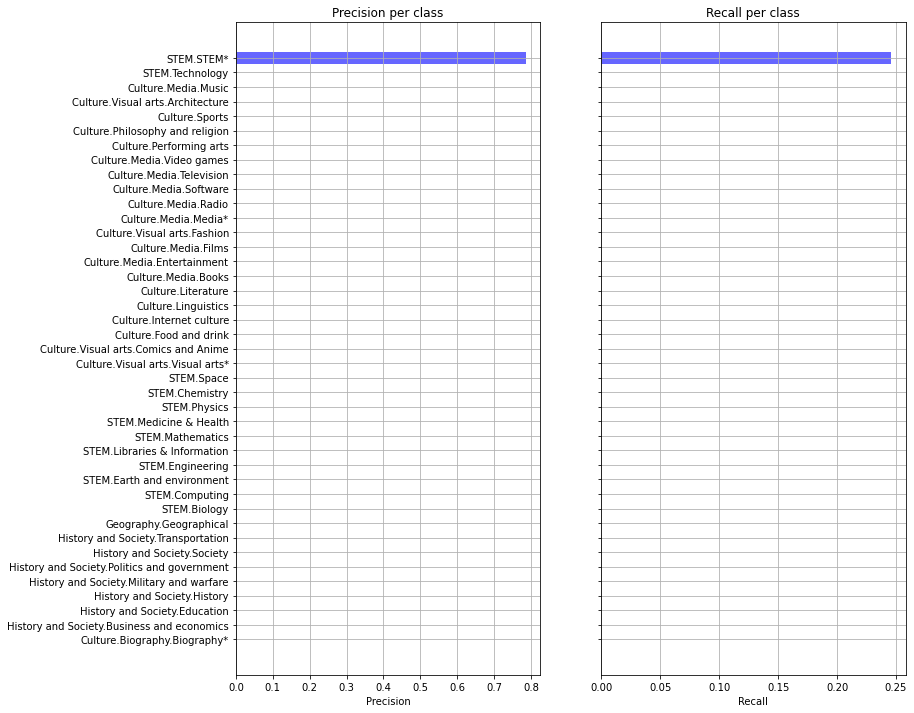

In [23]:
from sklearn.metrics import classification_report, average_precision_score, roc_auc_score

threshold = 0.2

y_pred = 1 * (val_predictions > threshold)

y_true = get_y_true(vg.classes)

n_classes = y_true.shape[1]
metrics_df = pd.DataFrame(classification_report(y_true, y_pred, target_names=list(vg.class_indices), output_dict=True)).transpose()
metrics_df['index'] = np.concatenate((np.arange(start=0, stop=n_classes), [None, None, None, None]))

# Output macro and micro accuracies
# with open(f'{self.results_path}/per_class_metrics', 'w') as f:
#     metrics_df.to_string(f)
# print(metrics_df.tail(4))

# Average precision score
# The average_precision_score function computes the average precision (AP) from prediction scores. The value is between 0 and 1 and higher is better. With random predictions, the AP is the fraction of positive samples.
print('\nAverage precision scores (macro):')
print(average_precision_score(y_true, y_pred, average='macro'))
# print(average_precision_score(y_true, y_pred, average='weighted'))

# ROC AUC score
print('\n ROC AUC score:')
print(roc_auc_score(y_true, val_predictions))

# Precision and recall for each class
fig, axs = plt.subplots(1, 2, figsize=(12,12))

# Precision
sorted_indices_precision = np.argsort(metrics_df.precision[0:n_classes])
sorted_precisions_per_class = metrics_df.precision[0:n_classes][sorted_indices_precision]
# Recall
sorted_indices_recall = np.argsort(metrics_df.recall[0:n_classes])
sorted_recalls_per_class = metrics_df.recall[0:n_classes][sorted_indices_recall]
# Plot!
axs[0].set_title('Precision per class')
axs[0].barh(range(y_true.shape[1]), sorted_precisions_per_class, color='blue', alpha=0.6)
axs[0].set_yticks(range(n_classes))
axs[0].set_yticklabels(np.array(list(vg.class_indices.keys()))[sorted_indices_precision])
axs[0].set_xlabel('Precision')
axs[0].grid(True)
axs[1].set_title('Recall per class')
axs[1].barh(range(y_true.shape[1]), sorted_recalls_per_class, color='blue', alpha=0.6)
axs[1].set_yticks(range(n_classes))
axs[1].set_yticklabels([])
axs[1].set_xlabel('Recall')
axs[1].grid(True)
plt.savefig(f'precision_recall.png')